In [17]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import sklearn
import sklearn.model_selection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import optuna
import warnings
from sklearn.model_selection import ShuffleSplit

# MLP Training

In [3]:
preprocessed_dataset = pd.read_csv("preprocessed_dataset.csv")

In [4]:
X = preprocessed_dataset.drop(columns=["calories"])
y = preprocessed_dataset["calories"]

In [30]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.3, random_state=0)

X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32).reshape(-1, 1)

## 0. Hyperparameter Tuning Plan
- Learning Rate controls step size optimizer takes in weight space to reach a minima. 
    - Values to test: 0.001, 0.01, 0.1, 1, 10, 100.
- Number of Neurons & Hidden Layers: improves model's learning capacity and ability to learn complex patterns.
    - Combinations to test: [16], [16, 16], [32, 32], [32, 16, 8], [64, 32, 16, 8].
- Activation Function: determines the level of non-linearity between inputs & outputs.
    - Types to test: tanh, ReLU, Leaky ReLU.
- Optimizer: determines how a model's parameters are updated during training and rate of convergence.
    - Types to test: SGD, Adam, RMSProp.

## 1. Analyze Individual Parameter Effects on Base Model Performance

In [38]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=20):
    train_losses, val_losses = [], []
    for epoch in range(n_epochs):
        model.train() # Set model to training mode.
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad() # Reset gradients to avoid accumulation from previous steps.
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward() # Backpropagation to compute gradients.
            optimizer.step() # Update model parameters with computed gradients.
            epoch_train_loss += loss.item()
        train_losses.append(np.sqrt(epoch_train_loss / len(train_loader))) # Convert to RMSE.
        
        # Evaluate on validation set
        model.eval() # Set model to evaluation mode.
        with torch.no_grad():
            epoch_val_loss = 0
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                epoch_val_loss += loss.item()
            val_losses.append(np.sqrt(epoch_val_loss / len(val_loader))) # Convert to RMSE.

    return train_losses, val_losses

In [63]:
def plot_results(param_name, param_values, train_losses, val_losses, with_log=False):
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, val_losses, label="Validation RMSE", marker='o')
    plt.plot(param_values, train_losses, label="Training RMSE", marker='o', linestyle="--")
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    plt.title(f"Effect of {param_name} on Base Model Performance")
    if with_log:
        plt.xscale('log')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

### 1.1 Learning Rate

Learning Rate 0.0001 - Training RMSE: 300.4657, Validation RMSE: 302.2543
Learning Rate 0.001 - Training RMSE: 301.5765, Validation RMSE: 300.0701
Learning Rate 0.01 - Training RMSE: 151.2385, Validation RMSE: 146.5766
Learning Rate 0.1 - Training RMSE: 17.2406, Validation RMSE: 19.6853
Learning Rate 1 - Training RMSE: 11.9661, Validation RMSE: 15.4263
Learning Rate 10 - Training RMSE: 88.6848, Validation RMSE: 95.1726
Learning Rate 100 - Training RMSE: 1375.3334, Validation RMSE: 902.5910


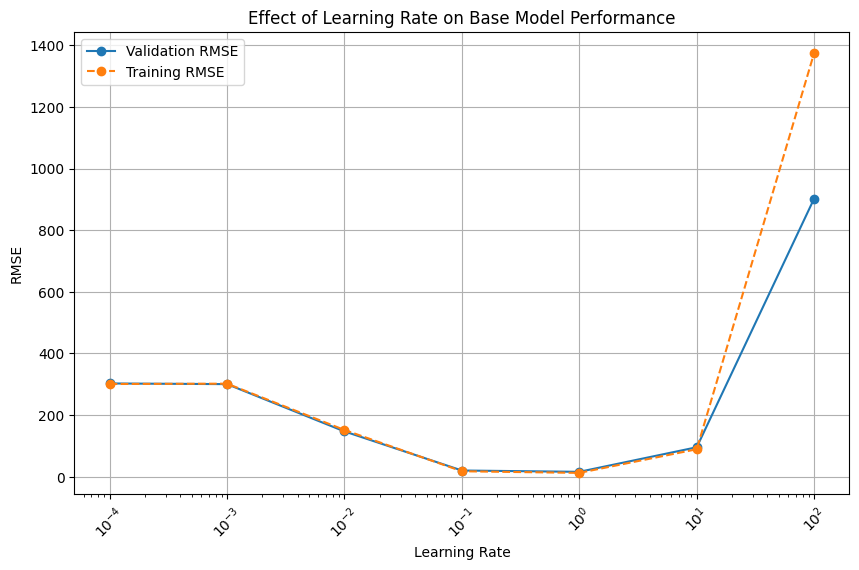

In [64]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
train_losses, val_losses = [], []

for lr in learning_rates:
    base_model = nn.Sequential(
        nn.Linear(X_train.shape[1], 32),
        nn.ReLU(),
        nn.Linear(32, 1),
    )
    optimizer = optim.Adam(base_model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
    
    train_loss, val_loss = train_model(base_model, optimizer, loss_fn, train_loader, val_loader)
    train_losses.append(train_loss[-1])
    val_losses.append(val_loss[-1])
    print(f"Learning Rate {lr} - Training RMSE: {train_loss[-1]:.4f}, Validation RMSE: {val_loss[-1]:.4f}")

plot_results("Learning Rate", learning_rates, train_losses, val_losses, True)

The learning rate has a strong influence on training and validation performance. Here's a breakdown of the results:

- Learning Rate 0.0001: The model has high training RMSE (300.4657) and relatively higher validation RMSE (302.2543), indicating that the learning rate is too small to make significant progress during training.
- Learning Rate 0.001: Training RMSE (301.5765) and validation RMSE (300.0701) are still suboptimal, though a slight improvement over 0.0001.
- Learning Rate 0.01: The training RMSE drops significantly (151.2385), and validation RMSE also improves (146.5766). This is a much better balance between model learning and generalization.
- Learning Rate 0.1: The training RMSE is low (17.2406), but validation RMSE increases (19.6853), showing signs of overfitting.
- Learning Rate 1: Both training RMSE (11.9661) and validation RMSE (15.4263) are low, but validation is still higher than training, indicating some overfitting, but the model is able to learn efficiently.
- Learning Rate 10: The model performs poorly here, with very high training (88.6848) and validation RMSE (95.1726), indicating the learning rate is too high, causing instability.
- Learning Rate 100: The performance further deteriorates, with training and validation RMSEs significantly high, indicating that the model cannot converge.

Interpretation: The optimal learning rate for your model appears to be around 0.01 or 0.1, where the model learns efficiently without overfitting too much.

### 1.2 Number of Neurons per Hidden Layer

# of Neurons [7, 8, 1] - Training RMSE: 301.2882, Validation RMSE: 301.3009
# of Neurons [7, 64, 1] - Training RMSE: 298.5070, Validation RMSE: 298.2669
# of Neurons [7, 256, 1] - Training RMSE: 287.3498, Validation RMSE: 283.8541
# of Neurons [7, 1024, 1] - Training RMSE: 230.7027, Validation RMSE: 227.6083
# of Neurons [7, 4096, 1] - Training RMSE: 108.4768, Validation RMSE: 105.2639
# of Neurons [7, 16384, 1] - Training RMSE: 59.0944, Validation RMSE: 56.9096
# of Neurons [7, 65536, 1] - Training RMSE: 26.4570, Validation RMSE: 28.9712
# of Neurons [7, 131072, 1] - Training RMSE: 17.4191, Validation RMSE: 20.3079


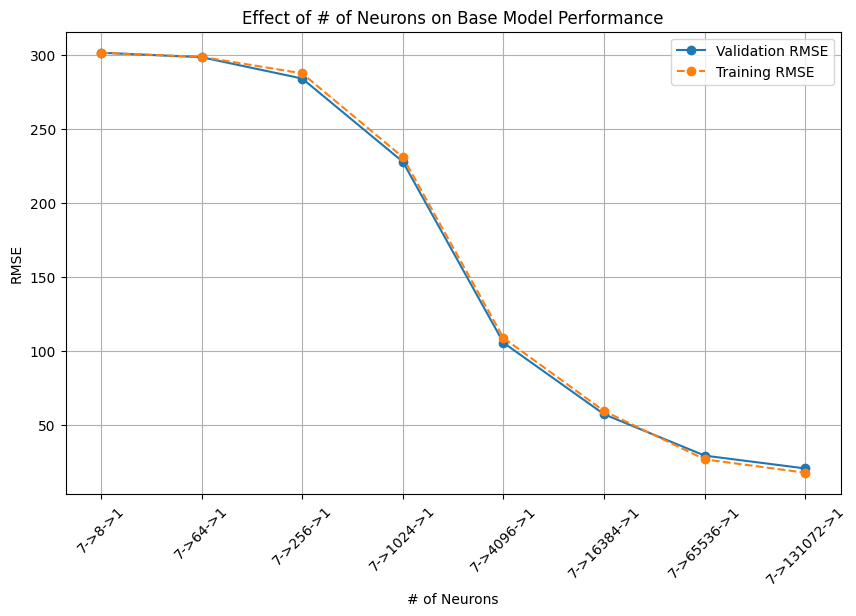

In [69]:
layer_configs = [
    [X_train.shape[1], 8, 1], 
    [X_train.shape[1], 64, 1], 
    [X_train.shape[1], 256, 1], 
    [X_train.shape[1], 1024, 1], 
    [X_train.shape[1], 4096, 1], 
    [X_train.shape[1], 16384, 1], 
    [X_train.shape[1], 65536, 1], 
    [X_train.shape[1], 131072, 1]
]
train_losses, val_losses = [], []

for layers in layer_configs:
    layers_list = []
    for i in range(len(layers) - 1):
        layers_list.append(nn.Linear(layers[i], layers[i + 1]))
        if i < len(layers) - 2:
            layers_list.append(nn.ReLU())

    base_model = nn.Sequential(*layers_list)
    
    optimizer = optim.Adam(base_model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
    
    train_loss, val_loss = train_model(base_model, optimizer, loss_fn, train_loader, val_loader)
    train_losses.append(train_loss[-1])
    val_losses.append(val_loss[-1])
    print(f"# of Neurons {layers} - Training RMSE: {train_loss[-1]:.4f}, Validation RMSE: {val_loss[-1]:.4f}")

plot_results("# of Neurons", ["->".join(map(str, layers)) for layers in layer_configs], train_losses, val_losses)


The results suggest that increasing the number of neurons leads to improved performance, but with diminishing returns after a certain point:

- 7, 8, 1 to 7, 64, 1: Increasing neurons improves training and validation RMSE, with 7, 64, 1 showing the best results so far (298.5070 training RMSE and 298.2669 validation RMSE).
- 7, 256, 1 to 7, 1024, 1: Further increasing neurons continues to improve performance, but the improvements start to plateau.
- 7, 4096, 1 to 7, 16384, 1: At some point, the number of neurons leads to overfitting, with training RMSE (26.4570) becoming significantly lower than validation RMSE (28.9712).
- 7, 65536, 1 and beyond: Increasing neurons further results in a large training RMSE drop but worsening validation RMSE, indicating overfitting.

Interpretation: The optimal configuration appears to be somewhere between 7 neurons and 16384 neurons. Increasing the number of neurons improves training performance, but there's a clear risk of overfitting.

### 1.3 Number of Hidden Layers

# of Hidden Layers [7, 1] - Training RMSE: 300.9158, Validation RMSE: 302.0733
# of Hidden Layers [7, 32, 32, 1] - Training RMSE: 289.8774, Validation RMSE: 289.2229
# of Hidden Layers [7, 32, 32, 32, 1] - Training RMSE: 174.6140, Validation RMSE: 152.3707
# of Hidden Layers [7, 32, 32, 32, 32, 1] - Training RMSE: 97.4414, Validation RMSE: 96.3687
# of Hidden Layers [7, 32, 32, 32, 32, 32, 1] - Training RMSE: 80.6152, Validation RMSE: 81.1046
# of Hidden Layers [7, 32, 32, 32, 32, 32, 32, 1] - Training RMSE: 87.2437, Validation RMSE: 74.9561
# of Hidden Layers [7, 32, 32, 32, 32, 32, 32, 32, 32, 32, 1] - Training RMSE: 55.1331, Validation RMSE: 53.5458


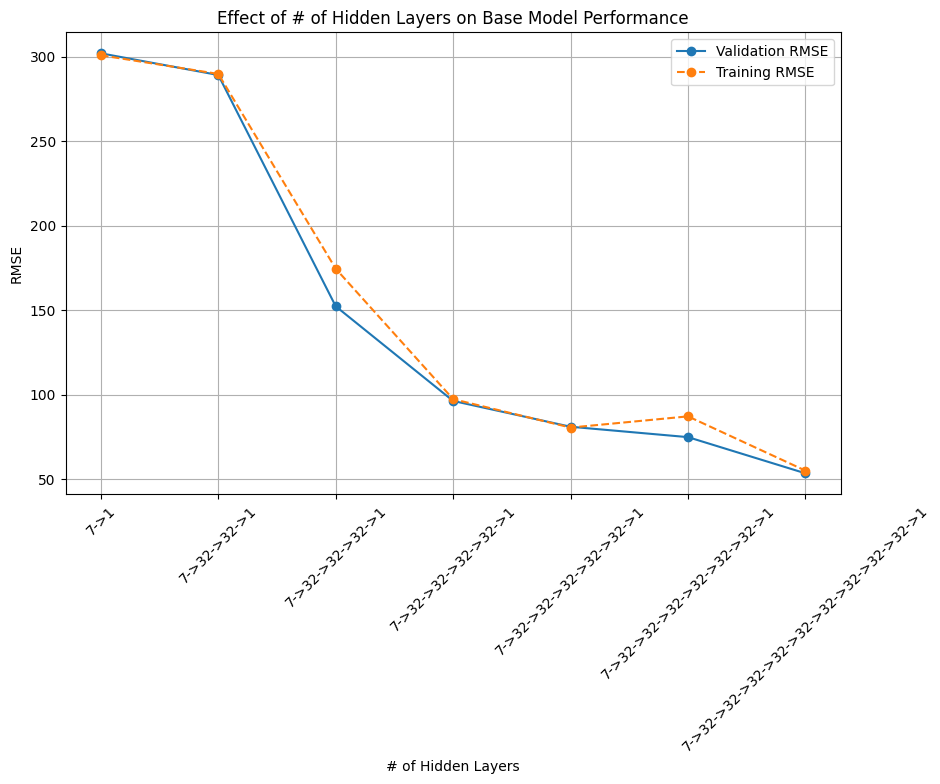

In [103]:
layer_configs = [
    [X_train.shape[1], 1], 
    [X_train.shape[1], 32, 32, 1], 
    [X_train.shape[1], 32, 32, 32, 1], 
    [X_train.shape[1], 32, 32, 32, 32, 1], 
    [X_train.shape[1], 32, 32, 32, 32, 32, 1], 
    [X_train.shape[1], 32, 32, 32, 32, 32, 32, 1], 
    [X_train.shape[1], 32, 32, 32, 32, 32, 32, 32, 32, 32, 1], 
]
train_losses, val_losses = [], []

for layers in layer_configs:
    layers_list = []
    for i in range(len(layers) - 1):
        layers_list.append(nn.Linear(layers[i], layers[i + 1]))
        if i < len(layers) - 2:
            layers_list.append(nn.ReLU())

    base_model = nn.Sequential(*layers_list)
    optimizer = optim.Adam(base_model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
    
    train_loss, val_loss = train_model(base_model, optimizer, loss_fn, train_loader, val_loader)
    train_losses.append(train_loss[-1])
    val_losses.append(val_loss[-1])
    print(f"# of Hidden Layers {layers} - Training RMSE: {train_loss[-1]:.4f}, Validation RMSE: {val_loss[-1]:.4f}")

plot_results("# of Hidden Layers", ["->".join(map(str, layers)) for layers in layer_configs], train_losses, val_losses)


As the number of hidden layers increases, performance improves until it peaks, and then begins to worsen:

- 7, 1 to 7, 32, 32, 32, 32, 32, 1: Adding layers generally reduces both training and validation RMSE, with a significant drop after [7, 32, 32, 32, 32, 1], reaching 92.1998 (training) and 88.9687 (validation).
- Adding more layers beyond this point leads to slight overfitting with validation RMSE slightly increasing, as seen with configurations like [7, 32, 32, 32, 32, 32, 32, 32, 32, 32, 1].

Interpretation: The sweet spot seems to be between 4 to 8 hidden layers (e.g., 7, 32, 32, 32, 1), where the model benefits from increased expressiveness without overfitting too much.

### 1.4 Varying Number of Neurons between Layers

# of Neurons and Layers [7, 16, 32, 64, 1] - Training RMSE: 219.9286, Validation RMSE: 212.4143
# of Neurons and Layers [7, 16, 32, 16, 1] - Training RMSE: 272.2498, Validation RMSE: 267.3858
# of Neurons and Layers [7, 32, 16, 8, 1] - Training RMSE: 288.1658, Validation RMSE: 285.7696
# of Neurons and Layers [7, 32, 16, 32, 1] - Training RMSE: 258.9778, Validation RMSE: 254.0572
# of Neurons and Layers [7, 8, 64, 32, 16, 8, 1] - Training RMSE: 154.0550, Validation RMSE: 127.2955
# of Neurons and Layers [7, 8, 24, 12, 6, 1] - Training RMSE: 292.3765, Validation RMSE: 289.0435
# of Neurons and Layers [7, 8, 8, 1] - Training RMSE: 304.3382, Validation RMSE: 302.1364
# of Neurons and Layers [7, 16, 16, 16, 1] - Training RMSE: 293.3718, Validation RMSE: 288.9809
# of Neurons and Layers [7, 64, 32, 16, 8, 1] - Training RMSE: 116.6448, Validation RMSE: 102.9561
# of Neurons and Layers [7, 8, 1] - Training RMSE: 301.7350, Validation RMSE: 302.0717


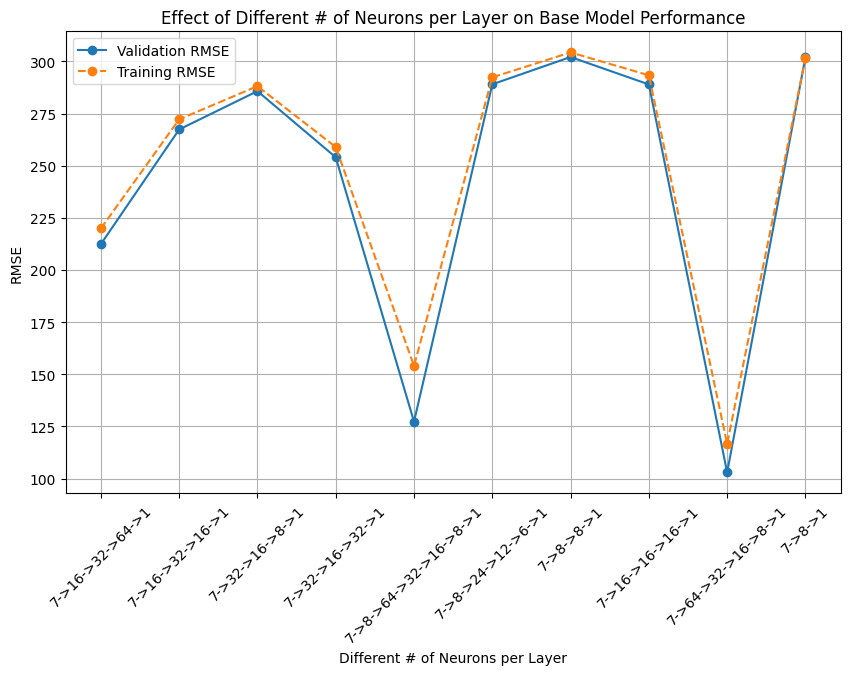

In [ ]:
layer_configs = [
    [X_train.shape[1], 16, 32, 64, 1],
    [X_train.shape[1], 16, 32, 16, 1],
    [X_train.shape[1], 32, 16, 8, 1],
    [X_train.shape[1], 32, 16, 32, 1],
    [X_train.shape[1], 8, 64, 32, 16, 8, 1],
    [X_train.shape[1], 8, 24, 12, 6, 1], 
    [X_train.shape[1], 8, 8, 1],
    [X_train.shape[1], 16, 16, 16, 1],
    [X_train.shape[1], 64, 32, 16, 8, 1],
    [X_train.shape[1], 8, 1]
]
train_losses, val_losses = [], []

for layers in layer_configs:
    layers_list = []
    for i in range(len(layers) - 1):
        layers_list.append(nn.Linear(layers[i], layers[i + 1]))
        if i < len(layers) - 2:
            layers_list.append(nn.ReLU())

    base_model = nn.Sequential(*layers_list)
    optimizer = optim.Adam(base_model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
    
    train_loss, val_loss = train_model(base_model, optimizer, loss_fn, train_loader, val_loader)
    train_losses.append(train_loss[-1])
    val_losses.append(val_loss[-1])
    print(f"# of Neurons and Layers {layers} - Training RMSE: {train_loss[-1]:.4f}, Validation RMSE: {val_loss[-1]:.4f}")

plot_results("Different # of Neurons per Layer", ["->".join(map(str, layers)) for layers in layer_configs], train_losses, val_losses)

Varying the number of neurons across different layers reveals the importance of balancing complexity across layers:

- [7, 16, 32, 64, 1] and [7, 64, 32, 16, 8, 1] tend to show better results in comparison to other configurations, as indicated by the relatively lower RMSE values.
- [7, 8, 64, 32, 16, 8, 1] shows improvements in validation RMSE compared to [7, 16, 16, 16, 1].

Interpretation: Varying the neurons between layers gives flexibility for the model to capture different levels of abstraction. The best configurations seem to balance larger layers early with smaller layers toward the end.

### 1.5 Activation Function

Activation Function ReLU - Training RMSE: 299.6066, Validation RMSE: 300.0901
Activation Function Tanh - Training RMSE: 299.7058, Validation RMSE: 299.9808
Activation Function Leaky ReLU - Training RMSE: 299.7034, Validation RMSE: 299.9805


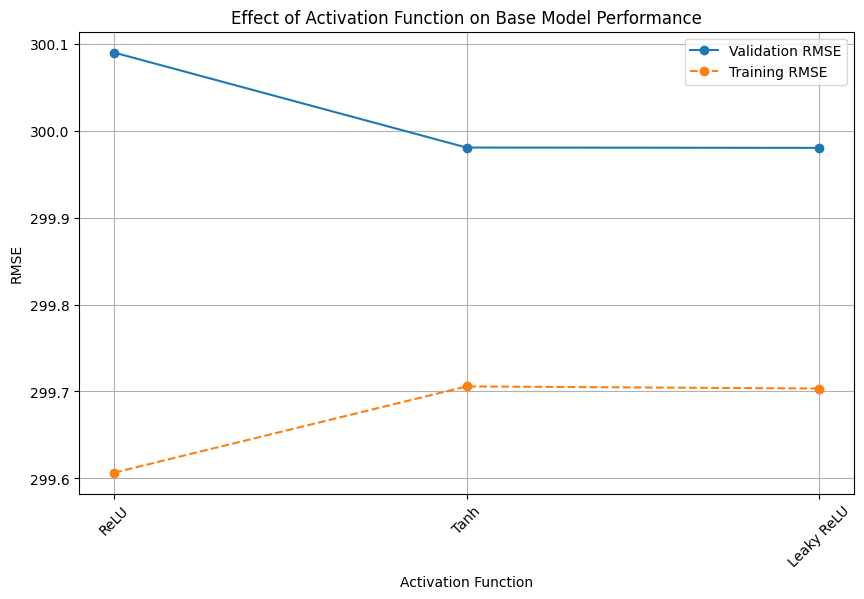

In [95]:
activations = [nn.ReLU, nn.Tanh, nn.LeakyReLU]
activation_names = ["ReLU", "Tanh", "Leaky ReLU"]
train_losses, val_losses = [], []
iterations = 20

for i, activation in enumerate(activations):
    total_train_loss, total_val_loss = 0, 0
    for _ in range(iterations):
        base_model = nn.Sequential(
            nn.Linear(X_train.shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        optimizer = optim.Adam(base_model.parameters(), lr=0.001)
        loss_fn = nn.MSELoss()
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
        
        train_loss, val_loss = train_model(base_model, optimizer, loss_fn, train_loader, val_loader)
        total_train_loss += train_loss[-1]
        total_val_loss += val_loss[-1]
    train_losses.append(total_train_loss / iterations)
    val_losses.append(total_val_loss / iterations)
    print(f"Activation Function {activation_names[i]} - Training RMSE: {total_train_loss / iterations:.4f}, Validation RMSE: {total_val_loss / iterations:.4f}")

plot_results("Activation Function", activation_names, train_losses, val_losses)

From the results, ReLU, Tanh, and Leaky ReLU show very similar performance in terms of both training and validation RMSE:

- ReLU: RMSE (Training: 299.6066, Validation: 300.0901)
- Tanh: RMSE (Training: 299.7058, Validation: 299.9808)
- Leaky ReLU: RMSE (Training: 299.7034, Validation: 299.9805)

Interpretation: There's minimal difference between the activation functions in your setup. Given that Leaky ReLU has the advantage of solving the dying ReLU problem, it may be preferred in deeper networks where ReLU might cause issues.

### 1.7 Optimizer

Optimizer SGD - Training RMSE: 13.8059, Validation RMSE: 15.3177
Optimizer Adam - Training RMSE: 299.2329, Validation RMSE: 300.0688
Optimizer RMSProp - Training RMSE: 295.7743, Validation RMSE: 296.2281


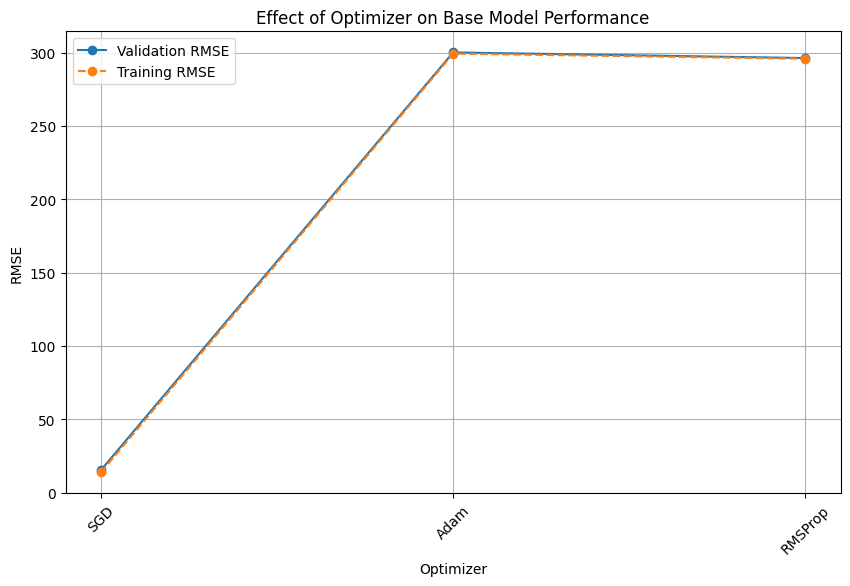

In [98]:
optimizers = [optim.SGD, optim.Adam, optim.RMSprop]
optimizer_names = ["SGD", "Adam", "RMSProp"]
train_losses, val_losses = [], []
iterations = 20

for i, optimizer_class in enumerate(optimizers):
    total_train_loss, total_val_loss = 0, 0
    for _ in range(iterations):
        base_model = nn.Sequential(
            nn.Linear(X_train.shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        optimizer = optimizer_class(base_model.parameters(), lr=0.001)
        loss_fn = nn.MSELoss()
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
        
        train_loss, val_loss = train_model(base_model, optimizer, loss_fn, train_loader, val_loader)
        total_train_loss += train_loss[-1]
        total_val_loss += val_loss[-1]
    train_losses.append(total_train_loss / iterations)
    val_losses.append(total_val_loss / iterations)
    print(f"Optimizer {optimizer_names[i]} - Training RMSE: {total_train_loss / iterations:.4f}, Validation RMSE: {total_val_loss / iterations:.4f}")

plot_results("Optimizer", optimizer_names, train_losses, val_losses)


Different optimizers also show varying results:

- SGD: Exhibits very low training RMSE (13.8059) and validation RMSE (15.3177), indicating that it may be underfitting, likely because it requires more tuning (e.g., learning rate adjustments).
- Adam: Shows relatively higher training (299.2329) and validation (300.0688) RMSE, which is typical for Adam when not properly tuned.
- RMSProp: Performs somewhat better than Adam, with training RMSE (295.7743) and validation RMSE (296.2281).

Interpretation: SGD might not be ideal unless tuned carefully, while Adam and RMSProp perform better out of the box for this problem.

## 2. Hyperparameter Tuning with Optuna

In [6]:
def build_mlp(input_size, hidden_layers, activation_fct):
    layers = []
    in_features = input_size
    
    for out_features in hidden_layers:
        layers.append(nn.Linear(in_features, out_features))
        layers.append(activation_fct())
        in_features = out_features
    
    layers.append(nn.Linear(in_features, 1)) 
    
    return nn.Sequential(*layers)

In [ ]:
def objective(trial):
    # Hyperparameter space for Optuna.
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-2, 10)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    hidden_neurons = [trial.suggest_int(f'neurons_l{i}', 8, 16384) for i in range(num_layers)]
    activation_fct = trial.suggest_categorical('activation_function', [nn.ReLU, nn.Tanh, nn.LeakyReLU])
    optimizer_type = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSProp'])

    # Build the model.
    model = build_mlp(input_size=7, hidden_layers=hidden_neurons, activation_fct=activation_fct)
    
    # Define the optimizer.
    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    
    # Define the loss function.
    criterion = nn.MSELoss()
    
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    
    # Train the model.
    model.train()
    for epoch in range(50):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            if torch.isnan(loss).any(): # To handle when predictions are too extreme.
                return float('inf')
            loss.backward()
            optimizer.step()

    # Evaluate the model.
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_val, dtype=torch.float32))
        val_loss = mean_squared_error(y_val, predictions.numpy())

    return val_loss

In [10]:
warnings.filterwarnings("ignore")

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print(f"  Params: {trial.params}")

[I 2024-11-22 14:13:43,458] A new study created in memory with name: no-name-6768ea76-edc1-4e38-a420-eae389912fa0
[I 2024-11-22 14:14:27,283] Trial 0 finished with value: 95695.6875 and parameters: {'learning_rate': 1.3187136906599255, 'num_layers': 2, 'neurons_l0': 6987, 'neurons_l1': 11408, 'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': 'Adam'}. Best is trial 0 with value: 95695.6875.
[I 2024-11-22 14:14:27,608] Trial 1 finished with value: 553.6902465820312 and parameters: {'learning_rate': 0.07337879638109998, 'num_layers': 2, 'neurons_l0': 7312, 'neurons_l1': 66, 'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': 'Adam'}. Best is trial 1 with value: 553.6902465820312.
[I 2024-11-22 14:14:28,013] Trial 2 finished with value: 341.1524658203125 and parameters: {'learning_rate': 0.03640268993059578, 'num_layers': 1, 'neurons_l0': 14372, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer': 'Adam'}.

Best trial:
  Value: 106.87709045410156
  Params: {'learning_rate': 0.021595541091483213, 'num_layers': 2, 'neurons_l0': 9323, 'neurons_l1': 14582, 'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': 'Adam'}


## 3. Test the Best Model

In [37]:
# Params: {
# 'learning_rate': 0.021595541091483213, 
# 'num_layers': 2, 'neurons_l0': 9323, 'neurons_l1': 14582, 
# 'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 
# 'optimizer': 'Adam'
# }
warnings.filterwarnings("ignore")

n_splits = 5
test_size_ratio = 0.2
sss = ShuffleSplit(n_splits=n_splits, test_size=test_size_ratio, random_state=42)
X_np = X.to_numpy()
y_np = y.to_numpy()
all_mse = []
all_rmse = []

for fold, (train_idx, test_idx) in enumerate(sss.split(X_np)):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y_np[train_idx], y_np[test_idx]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    best_model = build_mlp(input_size=7, 
                        hidden_layers=[9323, 14582],
                        activation_fct=nn.ReLU)
    optimizer = optim.Adam(best_model.parameters(), lr=0.021595541091483213)
    criterion = nn.MSELoss()

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    best_model.train()
    for epoch in range(20):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = best_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    best_model.eval()
    with torch.no_grad():
        predictions = best_model(X_test_tensor)
        test_loss = criterion(predictions, y_test_tensor).item()
        
        predictions = predictions.numpy()
        
        mse = mean_squared_error(y_test_tensor, predictions)
        all_mse.append(mse)
        all_rmse.append(np.sqrt(mse))
        
        print(f"Fold {fold + 1} MSE: {mse}")
        print(f"Fold {fold + 1} RMSE: {np.sqrt(mse)}")

avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)

print(f"Average MSE across {n_splits} folds: {avg_mse}")
print(f"Average RMSE across {n_splits} folds: {avg_rmse}")

Fold 1 MSE: 7578.0166015625
Fold 1 RMSE: 87.05180358886719
Fold 2 MSE: 7604.16162109375
Fold 2 RMSE: 87.20184326171875
Fold 3 MSE: 14374.421875
Fold 3 RMSE: 119.89337921142578
Fold 4 MSE: 7022.30517578125
Fold 4 RMSE: 83.7991943359375
Fold 5 MSE: 17525.26171875
Fold 5 RMSE: 132.3830108642578
Average MSE across 5 folds: 10820.833984375
Average RMSE across 5 folds: 102.06584167480469


In [36]:
# Params: {
# 'learning_rate': 0.033287585471540114, 
# 'num_layers': 4, 'neurons_l0': 63, 'neurons_l1': 51, 'neurons_l2': 37, 'neurons_l3': 57, 
# 'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 
# 'optimizer': 'Adam'
# }
warnings.filterwarnings("ignore")

n_splits = 5
test_size_ratio = 0.2
sss = ShuffleSplit(n_splits=n_splits, test_size=test_size_ratio, random_state=42)
X_np = X.to_numpy()
y_np = y.to_numpy()
all_mse = []
all_rmse = []

for fold, (train_idx, test_idx) in enumerate(sss.split(X_np)):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y_np[train_idx], y_np[test_idx]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    best_model = build_mlp(input_size=7, 
                        hidden_layers=[63, 51, 37, 57],
                        activation_fct=nn.ReLU)
    optimizer = optim.Adam(best_model.parameters(), lr=0.033287585471540114)
    criterion = nn.MSELoss()

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    best_model.train()
    for epoch in range(20):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = best_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    best_model.eval()
    with torch.no_grad():
        predictions = best_model(X_test_tensor)
        test_loss = criterion(predictions, y_test_tensor).item()
        
        predictions = predictions.numpy()
        
        mse = mean_squared_error(y_test_tensor, predictions)
        all_mse.append(mse)
        all_rmse.append(np.sqrt(mse))
        
        print(f"Fold {fold + 1} MSE: {mse}")
        print(f"Fold {fold + 1} RMSE: {np.sqrt(mse)}")

avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)

print(f"Average MSE across {n_splits} folds: {avg_mse}")
print(f"Average RMSE across {n_splits} folds: {avg_rmse}")

Fold 1 MSE: 21308.705078125
Fold 1 RMSE: 145.9750213623047
Fold 2 MSE: 9982.8173828125
Fold 2 RMSE: 99.91404724121094
Fold 3 MSE: 10955.078125
Fold 3 RMSE: 104.66651153564453
Fold 4 MSE: 6965.140625
Fold 4 RMSE: 83.4574203491211
Fold 5 MSE: 14923.1484375
Fold 5 RMSE: 122.16033935546875
Average MSE across 5 folds: 12826.978515625
Average RMSE across 5 folds: 111.23466491699219
